## RFM Segmentation CLV Calculation Ecommerce

### Import Libraries

In [1]:
import pandas as pd
from jdatetime import GregorianToJalali

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler

from kneed import KneeLocator
from scipy import stats

from typing import List, Tuple
from tabulate import tabulate

### Load Dataset

In [2]:
def load_data(file_path: str, index_col: str = 'Unnamed: 0') -> pd.DataFrame:
    """Load data from a CSV file into a DataFrame.
    
    Args:
        file_path (str): The path to the CSV file.
        index_col (str, optional): The column to use as the index. Defaults to 'Unnamed: 0'.
    
    Returns:
        pd.DataFrame: The loaded data.
    """
    
    return pd.read_csv(file_path, index_col=index_col)

In [3]:
def process_data(df: pd.DataFrame) -> pd.DataFrame:
    """Process a DataFrame to add and format date columns.
    
    Args:
        df (pd.DataFrame): The DataFrame to process.
    
    Returns:
        pd.DataFrame: The processed DataFrame.
    """
    
    df['Edited_Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
    
    df['Persian_Date'] = df['Edited_Date'].apply(
        lambda x: '-'.join(map(str, GregorianToJalali(x.year, x.month, x.day).getJalaliList()))
    )
    
    persian_date_parts = df['Persian_Date'].str.split('-')
    df['Persian_Year'] = pd.to_numeric(persian_date_parts.str[0], errors='coerce')
    df['Persian_Month'] = pd.to_numeric(persian_date_parts.str[1], errors='coerce')
    
    return df

In [4]:
def print_dataframe_stats(df: pd.DataFrame) -> None:
    """Print various statistics about a DataFrame.
    
    Args:
        df (pd.DataFrame): The DataFrame to print statistics for.
    """
    
    print(f"Rows   : {df.shape[0]}")
    print(f"Columns : {df.shape[1]}")
    print("\nFeatures : \n", df.columns.tolist())
    print("\nUnique values : \n", df.nunique())
    print("\nMissing values Total : ", df.isnull().sum().sum())
    print("\nMissing values : \n", df.isnull().sum())
    print("\nType of values: \n", df.dtypes)

In [5]:
data = load_data(r'Dataset.csv')
df = process_data(data)

In [6]:
print_dataframe_stats(df)

Rows   : 261960
Columns : 8

Features : 
 ['CustomerID', 'OrderID', 'Date', 'Revenue', 'Edited_Date', 'Persian_Date', 'Persian_Year', 'Persian_Month']

Unique values : 
 CustomerID       179680
OrderID          261960
Date                396
Revenue            3314
Edited_Date         396
Persian_Date        396
Persian_Year          2
Persian_Month        12
dtype: int64

Missing values Total :  0

Missing values : 
 CustomerID       0
OrderID          0
Date             0
Revenue          0
Edited_Date      0
Persian_Date     0
Persian_Year     0
Persian_Month    0
dtype: int64

Type of values: 
 CustomerID                int64
OrderID                   int64
Date                      int64
Revenue                   int64
Edited_Date      datetime64[ns]
Persian_Date             object
Persian_Year              int64
Persian_Month             int64
dtype: object


#### The number of customers, the number of orders, Average Order Value, Average Frequency, and total revenue are calculated (based on the Persian calendar).

In [7]:
def group_and_aggregate(df: pd.DataFrame, year: int, month_col: str, customer_id_col: str, order_id_col: str, revenue_col: str) -> pd.DataFrame:
    """Group and aggregate a DataFrame by month.
    
    Args:
        df (pd.DataFrame): The DataFrame to process.
        year (int): The year to filter the DataFrame by.
        month_col (str): The name of the month column.
        customer_id_col (str): The name of the customer ID column.
        order_id_col (str): The name of the order ID column.
        revenue_col (str): The name of the revenue column.
    
    Returns:
        pd.DataFrame: The grouped and aggregated DataFrame.
    """
    
    df_year = df[df['Persian_Year'] == year]

    result_df = df_year.groupby(month_col).agg({
        customer_id_col: 'nunique',     
        order_id_col: 'count',            
        revenue_col: ['sum', 'mean'], 
    })

    result_df.columns = ['Num_Customers', 'Num_Orders', 'Total_Revenue', 'Avg_Order_Value']
    result_df['Avg_Frequency'] = result_df['Num_Orders'] / result_df['Num_Customers']

    return result_df

In [8]:
def print_metrics(df: pd.DataFrame) -> None:
    metrics_to_display = ['Num_Customers', 'Num_Orders', 'Total_Revenue', 'Avg_Order_Value', 'Avg_Frequency']

    """Print specified metrics for each month in a DataFrame.
    
    Args:
        df (pd.DataFrame): The DataFrame to print metrics for.
    """
    
    pd.set_option('display.float_format', '${:,.0f}'.format)

    for metric in metrics_to_display:
        print("\n" + "=" * 50 + "\n") 
        print(f"{metric.replace('_', ' ')} in each month:")
        table = tabulate(df[[metric]].reset_index(), headers='keys', tablefmt='fancy_grid', showindex=False, floatfmt=".2f")
        print(table)

In [9]:
def print_metrics(df: pd.DataFrame) -> None:
    metrics_to_display = ['Num_Customers', 'Num_Orders', 'Total_Revenue', 'Avg_Order_Value', 'Avg_Frequency']

    """Print specified metrics for each month in a DataFrame.
    
    Args:
        df (pd.DataFrame): The DataFrame to print metrics for.
    """
    
    pd.set_option('display.float_format', '${:,.0f}'.format)

    for metric in metrics_to_display:
        print("\n" + "=" * 50 + "\n") 
        print(f"{metric.replace('_', ' ')} in each month:")
        table = tabulate(df[[metric]].reset_index(names='Persian_Month'), headers='keys', tablefmt='fancy_grid', showindex=False, floatfmt=".2f")
        print(table)
        

        plt.figure(figsize=(8, 5))
        data = df.copy()
        data.reset_index(inplace=True)

        plt.plot(data['Persian_Month'], data[metric], marker='o', linestyle='-', color='b')
        plt.title(f"{metric.replace('_', ' ')} in each mont")
        plt.xlabel('Persian_Month')
        plt.ylabel(metric.replace('_', ' '))
        plt.grid(True)
        plt.show()



Num Customers in each month:
╒═════════════════╤═════════════════╕
│   Persian_Month │   Num_Customers │
╞═════════════════╪═════════════════╡
│            1.00 │         2789.00 │
├─────────────────┼─────────────────┤
│            2.00 │         3064.00 │
├─────────────────┼─────────────────┤
│            3.00 │        12768.00 │
├─────────────────┼─────────────────┤
│            4.00 │        14122.00 │
├─────────────────┼─────────────────┤
│            5.00 │        24708.00 │
├─────────────────┼─────────────────┤
│            6.00 │        16603.00 │
├─────────────────┼─────────────────┤
│            7.00 │        22541.00 │
├─────────────────┼─────────────────┤
│            8.00 │        28594.00 │
├─────────────────┼─────────────────┤
│            9.00 │        27344.00 │
├─────────────────┼─────────────────┤
│           10.00 │        23048.00 │
├─────────────────┼─────────────────┤
│           11.00 │        23819.00 │
├─────────────────┼─────────────────┤
│           12.00 │

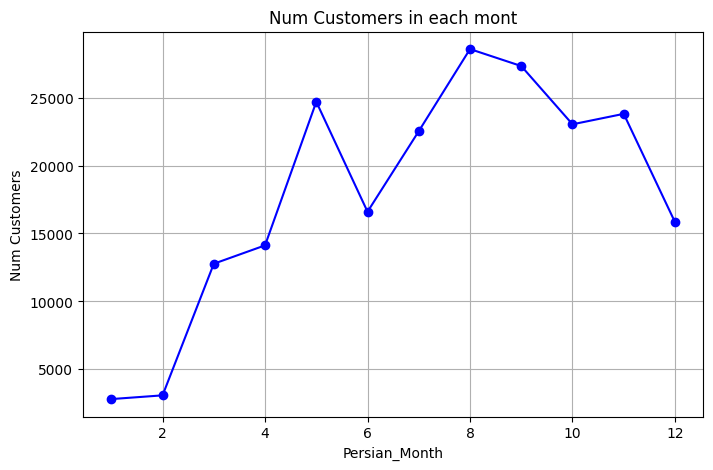



Num Orders in each month:
╒═════════════════╤══════════════╕
│   Persian_Month │   Num_Orders │
╞═════════════════╪══════════════╡
│            1.00 │      3279.00 │
├─────────────────┼──────────────┤
│            2.00 │      3503.00 │
├─────────────────┼──────────────┤
│            3.00 │     14380.00 │
├─────────────────┼──────────────┤
│            4.00 │     16228.00 │
├─────────────────┼──────────────┤
│            5.00 │     28663.00 │
├─────────────────┼──────────────┤
│            6.00 │     18630.00 │
├─────────────────┼──────────────┤
│            7.00 │     26699.00 │
├─────────────────┼──────────────┤
│            8.00 │     33233.00 │
├─────────────────┼──────────────┤
│            9.00 │     30989.00 │
├─────────────────┼──────────────┤
│           10.00 │     26642.00 │
├─────────────────┼──────────────┤
│           11.00 │     27839.00 │
├─────────────────┼──────────────┤
│           12.00 │     18227.00 │
╘═════════════════╧══════════════╛


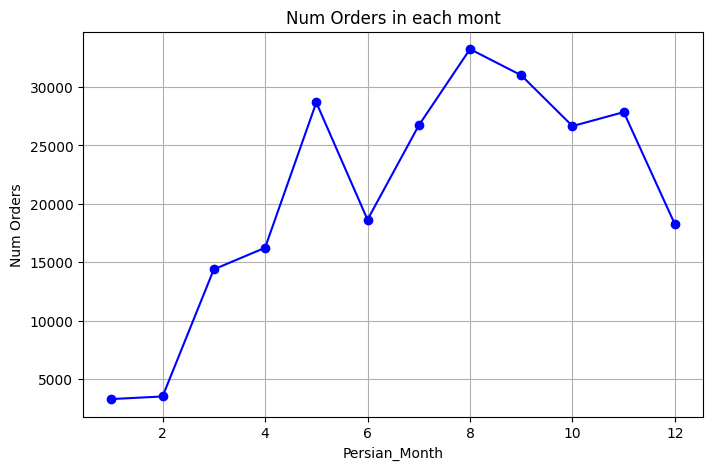



Total Revenue in each month:
╒═════════════════╤═════════════════╕
│   Persian_Month │   Total_Revenue │
╞═════════════════╪═════════════════╡
│            1.00 │     19618499.00 │
├─────────────────┼─────────────────┤
│            2.00 │     23860379.00 │
├─────────────────┼─────────────────┤
│            3.00 │     91363493.00 │
├─────────────────┼─────────────────┤
│            4.00 │    107350424.00 │
├─────────────────┼─────────────────┤
│            5.00 │    146502637.00 │
├─────────────────┼─────────────────┤
│            6.00 │    104375481.00 │
├─────────────────┼─────────────────┤
│            7.00 │    150623504.00 │
├─────────────────┼─────────────────┤
│            8.00 │    183010916.00 │
├─────────────────┼─────────────────┤
│            9.00 │    180390183.00 │
├─────────────────┼─────────────────┤
│           10.00 │    177407408.00 │
├─────────────────┼─────────────────┤
│           11.00 │    163590162.00 │
├─────────────────┼─────────────────┤
│           12.00 │

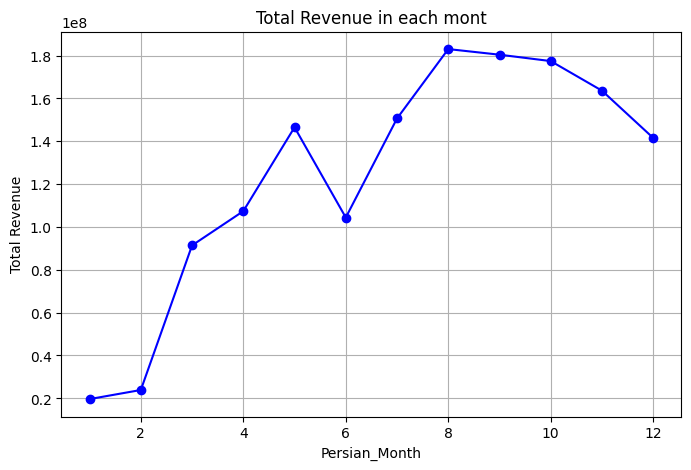



Avg Order Value in each month:
╒═════════════════╤═══════════════════╕
│   Persian_Month │   Avg_Order_Value │
╞═════════════════╪═══════════════════╡
│            1.00 │           5983.07 │
├─────────────────┼───────────────────┤
│            2.00 │           6811.41 │
├─────────────────┼───────────────────┤
│            3.00 │           6353.51 │
├─────────────────┼───────────────────┤
│            4.00 │           6615.14 │
├─────────────────┼───────────────────┤
│            5.00 │           5111.21 │
├─────────────────┼───────────────────┤
│            6.00 │           5602.55 │
├─────────────────┼───────────────────┤
│            7.00 │           5641.54 │
├─────────────────┼───────────────────┤
│            8.00 │           5506.90 │
├─────────────────┼───────────────────┤
│            9.00 │           5821.10 │
├─────────────────┼───────────────────┤
│           10.00 │           6658.94 │
├─────────────────┼───────────────────┤
│           11.00 │           5876.29 │
├──────

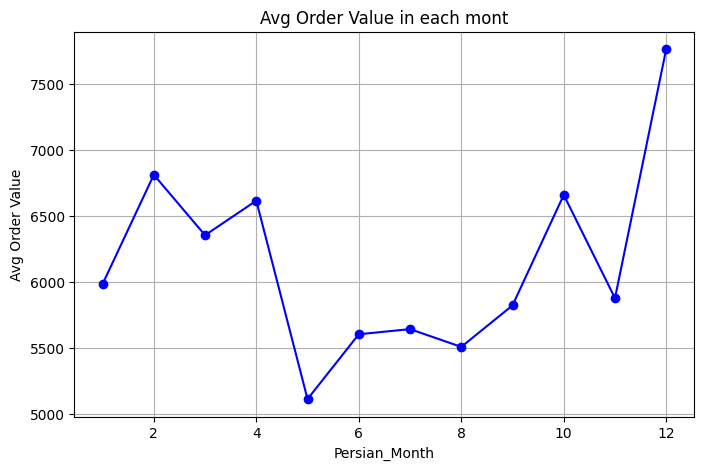



Avg Frequency in each month:
╒═════════════════╤═════════════════╕
│   Persian_Month │   Avg_Frequency │
╞═════════════════╪═════════════════╡
│            1.00 │            1.18 │
├─────────────────┼─────────────────┤
│            2.00 │            1.14 │
├─────────────────┼─────────────────┤
│            3.00 │            1.13 │
├─────────────────┼─────────────────┤
│            4.00 │            1.15 │
├─────────────────┼─────────────────┤
│            5.00 │            1.16 │
├─────────────────┼─────────────────┤
│            6.00 │            1.12 │
├─────────────────┼─────────────────┤
│            7.00 │            1.18 │
├─────────────────┼─────────────────┤
│            8.00 │            1.16 │
├─────────────────┼─────────────────┤
│            9.00 │            1.13 │
├─────────────────┼─────────────────┤
│           10.00 │            1.16 │
├─────────────────┼─────────────────┤
│           11.00 │            1.17 │
├─────────────────┼─────────────────┤
│           12.00 │

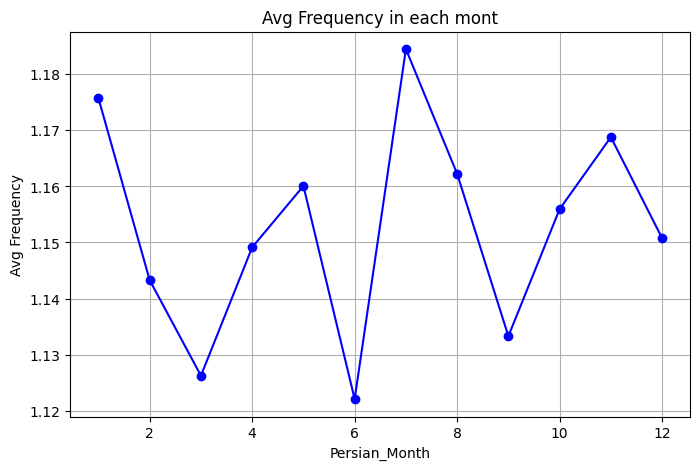

In [10]:
df_result_year = group_and_aggregate(df, 1398, 'Persian_Month', 'CustomerID', 'OrderID', 'Revenue')
print_metrics(df_result_year)

### The month with the most orders

In [11]:
def find_month_with_max(metric: str, df: pd.DataFrame) -> str:
    """Find the month with the maximum value for a given metric in a DataFrame.
    
    Args:
        metric (str): The metric to find the maximum value for.
        df (pd.DataFrame): The DataFrame to search.
    
    Returns:
        str: The name of the month with the maximum value for the metric.
    """
    
    PERSIAN_MONTH_NAMES = {
    1: 'Farvardin',
    2: 'Ordibehesht',
    3: 'Khordad',
    4: 'Tir',
    5: 'Mordad',
    6: 'Shahrivar',
    7: 'Mehr',
    8: 'Aban',
    9: 'Azar',
    10: 'Dey',
    11: 'Bahman',
    12: 'Esfand'
    }

    max_month = df[metric].idxmax()
    return PERSIAN_MONTH_NAMES[max_month]

In [12]:
def print_month_with_max_orders_and_revenue(df: pd.DataFrame, orders_col: str = 'Num_Orders', revenue_col: str = 'Total_Revenue') -> None:
    """Print the month with the maximum number of orders and total revenue in a DataFrame.
    
    Args:
        df (pd.DataFrame): The DataFrame to search.
        orders_col (str, optional): The name of the orders column. Defaults to 'Num_Orders'.
        revenue_col (str, optional): The name of the revenue column. Defaults to 'Total_Revenue'.
    """
    
    max_orders_month = find_month_with_max(orders_col, df)
    max_revenue_month = find_month_with_max(revenue_col, df)

    if max_orders_month == max_revenue_month:
        print(f"The month with the highest number of orders and highest total revenue is: {max_orders_month}")
    else:
        print("There is no month that satisfies both conditions.")
        print(f'The month with the highest number of orders is : {max_orders_month}')
        print(f'The month with the highest total revenue is: {max_revenue_month}')

In [13]:
print_month_with_max_orders_and_revenue(df_result_year)

The month with the highest number of orders and highest total revenue is: Aban


### Segment Customers based on the RFM model

#### Implementation of the RFM Model without a Machine Learning Model


In [14]:
def calculate_rfm_scores(df: pd.DataFrame) -> pd.DataFrame:
   """Calculate RFM scores for a DataFrame.
   
   Args:
       df (pd.DataFrame): The DataFrame to calculate RFM scores for.
   
   Returns:
       pd.DataFrame: The DataFrame with RFM scores.
   """
   
   end_date = df['Edited_Date'].max()
   start_date = end_date - pd.DateOffset(months=6)
   filtered_df = df[(df['Edited_Date'] >= start_date) & (df['Edited_Date'] <= end_date)]

   df_rfm = filtered_df.groupby('CustomerID').agg({
       'Edited_Date': lambda x: (end_date - x.max()).days, # Recency
       'OrderID': lambda OrderID: OrderID.nunique(),       # Frequency
       'Revenue': lambda Revenue: Revenue.sum()            # Monetary 
   })

   df_rfm.columns = ['Recency', 'Frequency', 'Monetary']

   df_rfm["RecencyScore"] = pd.qcut(df_rfm['Recency'], 4, [4, 3, 2, 1])
   df_rfm["FrequencyScore"] = pd.qcut(df_rfm['Frequency'].rank(method="first"), 4, [1, 2, 3, 4])
   df_rfm["MonetaryScore"] = pd.qcut(df_rfm['Monetary'], 4, [1, 2, 3, 4])

   df_rfm['RFM Score'] = df_rfm['RecencyScore'].astype(str) + df_rfm['FrequencyScore'].astype(str) + df_rfm['MonetaryScore'].astype(str)
   df_rfm['RFM Score'] = df_rfm['RFM Score'].astype(int)

   df_rfm['FxM Label'] = (pd.to_numeric(df_rfm['FrequencyScore']) + pd.to_numeric(df_rfm['MonetaryScore'])) / 2
   df_rfm['RecencyScore'] = df_rfm['RecencyScore'].astype(int)

   return df_rfm

In [15]:
def categorize_rfm(recency_score: int, fxm_label: float) -> str:
    """Categorize a customer based on their recency score and fxm label.
    
    Args:
        recency_score (int): The recency score of the customer.
        fxm_label (float): The fxm label of the customer.
    
    Returns:
        str: The category of the customer.
    """
    
    if recency_score == 1 and 3.5 <= fxm_label <= 4:
        return 'Champion'
    elif recency_score == 2 and 3.5 <= fxm_label <= 4:
        return 'Loyal Customer'
    elif 1 <= recency_score <= 2 and 2.5 <= fxm_label <= 3:
        return 'Potential Loyalist'
    elif recency_score == 1 and 1 <= fxm_label <= 2:
        return 'New'
    elif recency_score == 2 and 1 <= fxm_label <= 2:
        return 'Promising'
    elif recency_score == 3 and 2.5 <= fxm_label <= 3.5:
        return 'Need Attention'
    elif recency_score == 3 and 1 <= fxm_label <= 2:
        return 'Sleep'
    elif 3 <= recency_score <= 4 and 3.5 <= fxm_label <= 4:
        return 'Can\'t Lose'
    elif recency_score == 4 and fxm_label == 1:
        return 'Hibernating'
    elif recency_score == 4 and 1.5 <= fxm_label <= 3:
        return 'At Risk'
    else:
        return 'Unknown'

In [16]:
def categorize_rfm_main_category(rfm_category: str) -> str:
    """Categorize a customer as 'Hot' or 'Cold' based on their RFM category.
    
    Args:
        rfm_category (str): The RFM category of the customer.
    
    Returns:
        str: The main category of the customer.
    """
    
    hot_categories = {'Champion', 'Loyal Customer', 'Potential Loyalist', 'New', 'Promising'}
    
    return 'Hot' if rfm_category in hot_categories else 'Cold'

In [17]:
def rfm_categorization(df: pd.DataFrame) -> pd.DataFrame:
    """Categorize customers in a DataFrame based on their RFM scores and labels.
    
    Args:
        df (pd.DataFrame): The DataFrame to categorize.
    
    Returns:
        pd.DataFrame: The categorized DataFrame.
    """
    
    df = calculate_rfm_scores(df)
    df['RFM Category'] = df.apply(lambda row: categorize_rfm(row['RecencyScore'], row['FxM Label']), axis=1)
    df['RFM Main Category'] = df['RFM Category'].apply(categorize_rfm_main_category)
    
    return df

In [18]:
def plot_treemap(segments: pd.DataFrame, title: str = "") -> None:
   """Plot a treemap of customer segments.
   
   Args:
       segments (pd.DataFrame): The DataFrame containing the segments to plot.
       title (str, optional): The title of the plot. Defaults to "".
   """

   fig = go.Figure(go.Treemap(
       labels=segments["Segment"],
       parents=[""] * len(segments["Segment"]),
       values=segments["Count"],
       text=segments["Count"].astype(str),
       hoverinfo="label+value+percent entry",
       marker=dict(line=dict(width=1, color='white')),
   ))

   fig.update_layout(
       title=f"{title} - Customer Segmentation Map",
       margin=dict(l=0, r=0, t=50, b=10),
   )
   fig.show()


def plot_countplot(df_rfm: pd.DataFrame, title: str = "") -> None:
   """Plot a countplot of RFM categories.
   
   Args:
       df_rfm (pd.DataFrame): The DataFrame containing the RFM categories to plot.
       title (str, optional): The title of the plot. Defaults to "".
   """

   value_counts = df_rfm["RFM Category"].value_counts()
   order = value_counts.index

   sns.countplot(x=df_rfm["RFM Category"], palette="husl", hue=df_rfm["RFM Category"], order=order)
   plt.title(f"{title} - RFM Category Counts")
   plt.xticks(rotation=70)
   plt.show()


def plot_main_category_countplot(df_rfm: pd.DataFrame, title: str = "") -> None:
   """Plot a countplot of RFM main categories.

   Args:
       df_rfm (pd.DataFrame): The DataFrame containing the RFM main categories to plot.
       title (str, optional): The title of the plot. Defaults to "".
   """
   
   custom_palette = {'Hot': 'orange', 'Cold': 'blue'}
   plt.figure(figsize=(8, 5))

   ax = sns.countplot(data=df_rfm, x="RFM Main Category", hue="RFM Main Category", palette=custom_palette)

   for p in ax.patches:
       ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

   plt.title(f"{title} - RFM Main Category Counts")
   plt.show()

In [19]:
def plot_rfm_segments(df_rfm: pd.DataFrame) -> None:
   """Plot RFM segments for a DataFrame.
   
   Args:
       df_rfm (pd.DataFrame): The DataFrame with RFM scores.
   """
   
   segments = df_rfm["RFM Category"].value_counts().reset_index()
   segments.columns = ["Segment", "Count"]

   plot_treemap(segments, title="RFM Segmentation")
   plot_countplot(df_rfm, title=" RFM Category Distribution")
   plot_main_category_countplot(df_rfm, title="RFM Main Category Distribution")

In [20]:
df_rfm = rfm_categorization(df)
df_rfm.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM Score,FxM Label,RFM Category,RFM Main Category
CustomerID,,,,,,,,,,
465132,141,1,7302,2,1,3,213,$2,Promising,Hot
465164,51,1,578,4,1,1,411,$1,Hibernating,Cold
465198,6,1,5688,4,1,3,413,$2,At Risk,Cold
465204,168,1,1464,1,1,1,111,$1,New,Hot
465211,88,1,4760,3,1,2,312,$2,Sleep,Cold


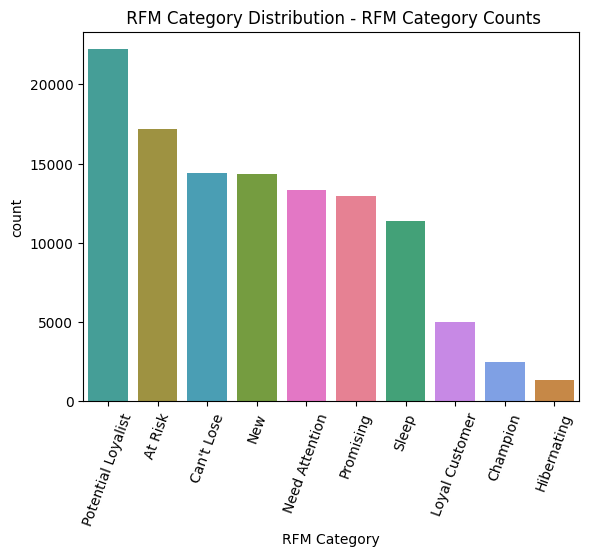

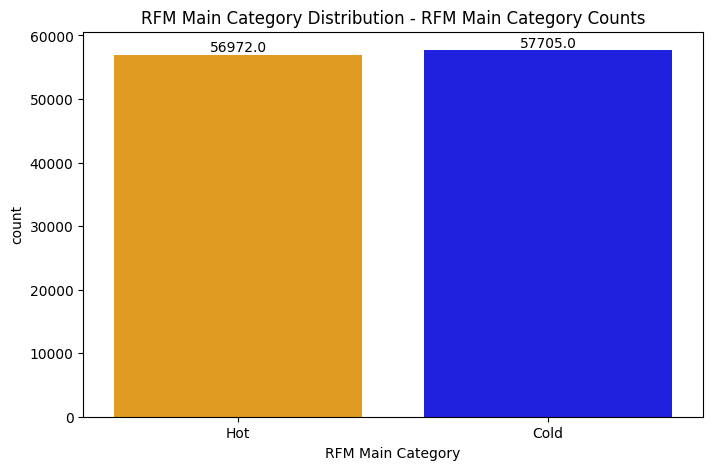

In [21]:
plot_rfm_segments(df_rfm)

### K-Means Implementation

In [22]:
def check_skew(df, column):
    """
    Plot the distribution and print skewness information for a specific column.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - column (str): The column for which the distribution will be plotted.

    Returns:
    None
    """
    
    skew = stats.skew(df[column])
    skewtest = stats.skewtest(df[column])

    plt.title(f'Distribution of {column}')
    sns.histplot(df[column], bins=30, color='blue', kde=True)

    print(f"{column}'s: Skew: {skew}, Skewtest: {skewtest}")


def plot_multiple_skewness(df, columns):
    """
    Plot the distribution and skewness information for multiple columns.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - columns (list): A list of column names to plot.

    Returns:
    None
    """
    plt.figure(figsize=(9, len(columns) * 3))

    for i, column in enumerate(columns, start=1):
        plt.subplot(len(columns), 1, i)
        check_skew(df, column)

    plt.tight_layout()
    plt.show()

Recency's: Skew: -0.185444510106593, Skewtest: SkewtestResult(statistic=-25.42380156957226, pvalue=1.3760564446420927e-142)
Frequency's: Skew: 28.146225761601684, Skewtest: SkewtestResult(statistic=477.94481274085166, pvalue=0.0)
Monetary's: Skew: 47.654202544332364, Skewtest: SkewtestResult(statistic=537.376871871988, pvalue=0.0)


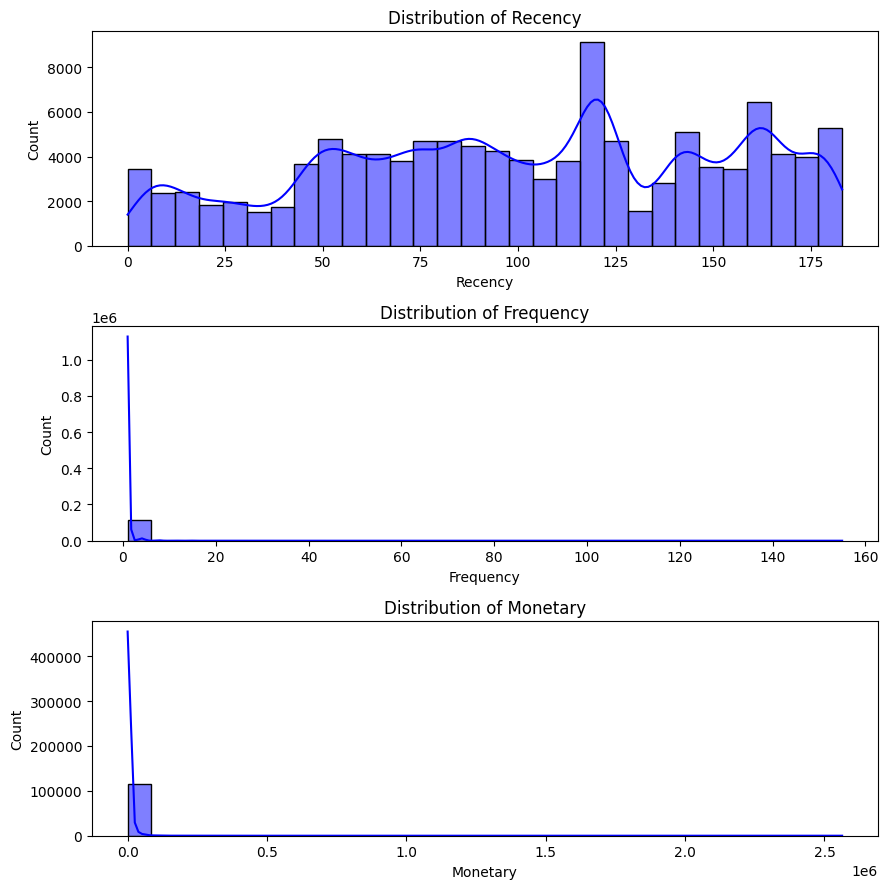

In [23]:
columns_to_plot = ['Recency', 'Frequency', 'Monetary']

plot_multiple_skewness(df_rfm, columns_to_plot)

The skewness analysis of the RFM (Recency, Frequency, Monetary) metrics reveals the following:

Recency:

Slightly leftward skew (negative skewness).
Statistically significant skewness with a very low p-value.
The distribution is skewed towards lower recency values.

Frequency:

Highly right-skewed distribution (high positive skewness).
Highly statistically significant skewness with a p-value of 0.0.
Concentration of lower frequency values, indicating a long tail of higher values.

Monetary:

Strong rightward skew (high positive skewness).
Statistically significant skewness with a very low p-value.
Concentration towards lower monetary values, similar to Frequency.

#### Based on the findings, addressing skewed data is essential.

In [24]:
def plot_box_plot(df, figsize=(10, 6)):
    plt.figure(figsize=figsize)

    plt.subplot(2, 2, 1)
    sns.boxplot(x=df['Recency'], color='blue')
    plt.title('Recency Boxplot')

    plt.subplot(2, 2, 2)
    sns.boxplot(x=df['Frequency'], color='green')
    plt.title('Frequency Boxplot')

    plt.subplot(2, 2, 3)
    sns.boxplot(x=df['Monetary'], color='orange')
    plt.title('Monetary Boxplot')

    plt.tight_layout()
    plt.show()

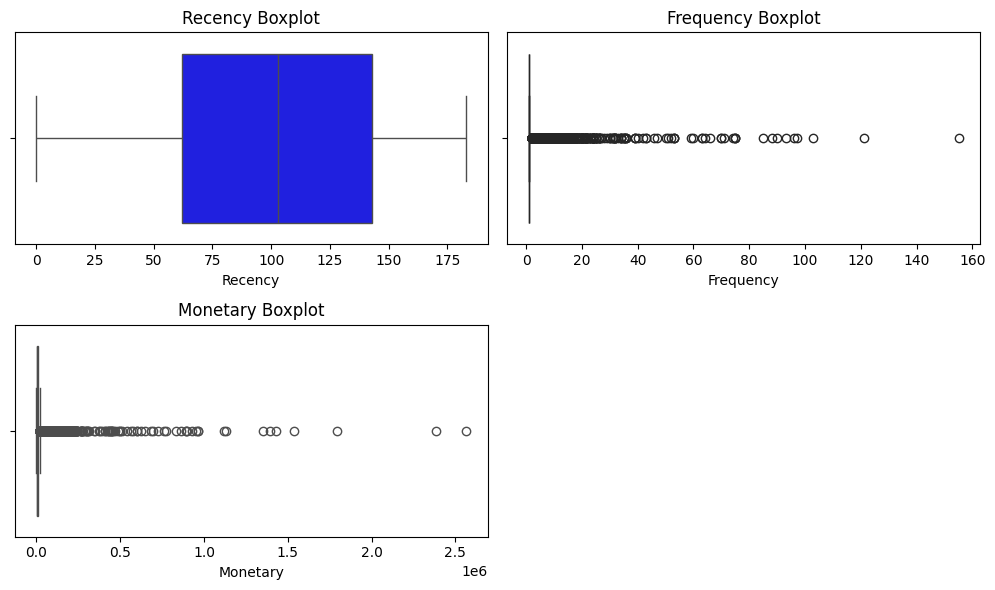

In [25]:
plot_box_plot(df_rfm)

In [26]:
def remove_outliers(df: pd.DataFrame, columns_to_transform: List[str]) -> pd.DataFrame:
    """
    Remove outliers from the specified columns in a DataFrame using the IQR method.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - columns_to_transform (List[str]): List of column names to remove outliers from.

    Returns:
    pd.DataFrame: DataFrame with outliers removed.
    """

    data = df.copy()

    for column in columns_to_transform:

        Q1, Q3 = data[column].quantile([0.25, 0.75])
        IQR = 1.5 * (Q3 - Q1)

        data = data.loc[~((data[column] < Q1 - IQR) | (data[column] > Q3 + IQR))]

    return data


def standardize_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Standardizes the given data using the StandardScaler from sklearn.

    Parameters:
    data (pd.DataFrame): The input data.

    Returns:
    pd.DataFrame: The standardized data.
    """

    scaler = StandardScaler()
    standardized_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

    return standardized_data


def apply_kmeans(data: pd.DataFrame, ideal_clusters: int) -> pd.DataFrame:
   """
   Applies the KMeans algorithm to the given data using the specified number of clusters.

   Parameters:
   data (pd.DataFrame): The input data.
   ideal_clusters (int): The number of clusters to use in the KMeans algorithm.

   Returns:
   pd.DataFrame: The data with an additional 'Cluster' column added by the KMeans algorithm.
   """
   
   kmeans = KMeans(n_clusters=ideal_clusters, random_state=42, n_init=10)

   columns_for_clustering = ['Recency', 'Frequency', 'Monetary']
   data_for_clustering = data[columns_for_clustering]

   scaler = StandardScaler()
   data_scaled = scaler.fit_transform(data_for_clustering)
   
   data = data.copy()
   data.loc[:, 'Cluster'] = kmeans.fit_predict(data_scaled)
   
   return data

In [27]:
def find_optimal_clusters(data: pd.DataFrame, cluster_numbers: List[int]) -> Tuple[int, List[float]]:
    """
    Find the optimal number of clusters for the given data.

    Args:
        data (pd.DataFrame): The data to be clustered.
        cluster_numbers (List[int]): The range of cluster numbers to try.

    Returns:
        Tuple[int, List[float]]: The optimal number of clusters and the corresponding distortions.
    """
    
    rfm_scaled = standardize_data(data)
    distortions = [KMeans(n_clusters=cluster_number, n_init=10).fit(rfm_scaled).inertia_ for cluster_number in cluster_numbers]
    
    knee_locator = KneeLocator(cluster_numbers, distortions, curve="convex", direction="decreasing")
    ideal_clusters = knee_locator.elbow + 1

    return ideal_clusters, distortions


def plot_elbow_method(data: pd.DataFrame, cluster_numbers: List[int]) -> None:
   """
   Plots the elbow method for optimal k using the given data and cluster numbers.

   Parameters:
   data (pd.DataFrame): The input data.
   cluster_numbers (List[int]): The list of cluster numbers to consider.

   Returns:
   None
   """

   ideal_clusters, distortions = find_optimal_clusters(data, cluster_numbers)

   plt.plot(cluster_numbers, distortions, marker='o')
   plt.xlabel('Number of Clusters (k)')
   plt.ylabel('Inertia')
   plt.title('Elbow Method for Optimal k')
   plt.vlines(ideal_clusters, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label='Ideal Clusters')
   plt.legend()
   plt.show()

In [28]:
def plot_scatter_matrix(data: pd.DataFrame, cluster_column: str) -> None:
    """
    Plots a scatter matrix for the given data and cluster column.

    Parameters:
    data (pd.DataFrame): The input data.
    cluster_column (str): The column to use for coloring the scatter plots.

    Returns:
    None
    """
    
    sns.set(style="whitegrid")
    features = ['Recency', 'Monetary']
    num_features = len(features)

    plt.figure(figsize=(12, 4 * num_features))

    for i, feature_x in enumerate(features):
        for j, feature_y in enumerate(features):
            if i < j:
                plt.subplot(num_features, num_features, i * num_features + j + 1)
                sns.scatterplot(x=feature_x, y=feature_y, hue=cluster_column, data=data, palette='viridis')
                plt.title(f'{feature_x} vs. {feature_y}')

    plt.tight_layout()
    plt.show()

In [29]:
def plot_clusters_3d(data: pd.DataFrame):
    """
    Create a 3D scatter plot to visualize clusters.

    Parameters:
    data (pd.DataFrame): The data with a 'Cluster' column.

    Returns:
    None
    """
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for cluster_id in data['Cluster'].unique():
        cluster_data = data[data['Cluster'] == cluster_id]
        ax.scatter(cluster_data['Recency'], cluster_data['Frequency'], cluster_data['Monetary'], label=f'Cluster {cluster_id}')

    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Monetary')
    ax.set_title('KMeans Clustering - 3D Scatter Plot')
    ax.legend()

    plt.show()

In [30]:
df_rfm_clean_outliers = remove_outliers(df_rfm[['Recency', 'Frequency', 'Monetary']], ['Frequency', 'Monetary'])

cluster_numbers_to_try = range(1, 15)
optimal_clusters, distortions = find_optimal_clusters(df_rfm_clean_outliers, cluster_numbers_to_try)

df_rfm_with_clusters = apply_kmeans(df_rfm_clean_outliers, optimal_clusters)

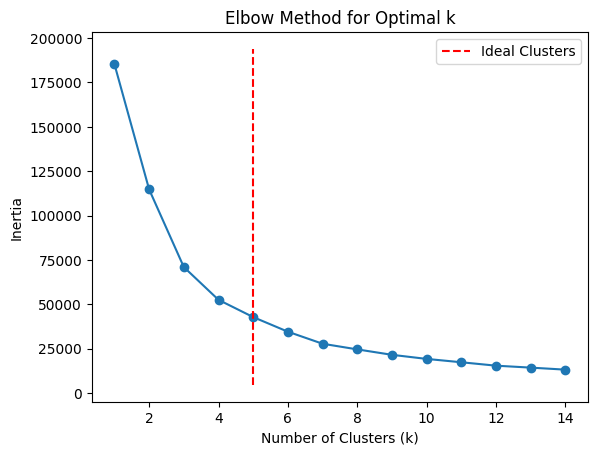

The number of ideal clusters is: 5


In [31]:
cluster_numbers = range(1, 15)

ideal_clusters, distortions = find_optimal_clusters(df_rfm_with_clusters[['Recency', 'Frequency', 'Monetary']], cluster_numbers)

plot_elbow_method(df_rfm_with_clusters[['Recency', 'Frequency', 'Monetary']], cluster_numbers)

print(f"The number of ideal clusters is: {ideal_clusters}")

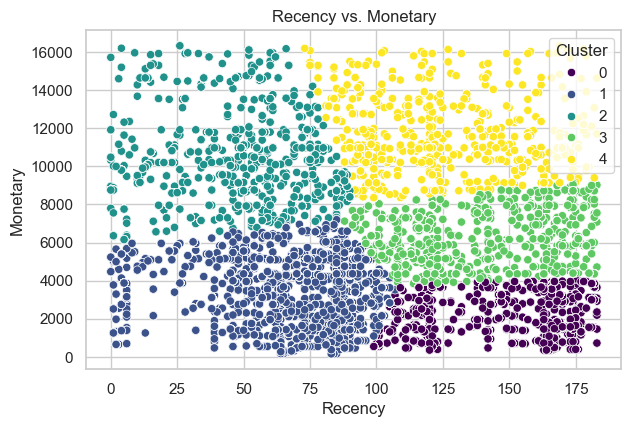

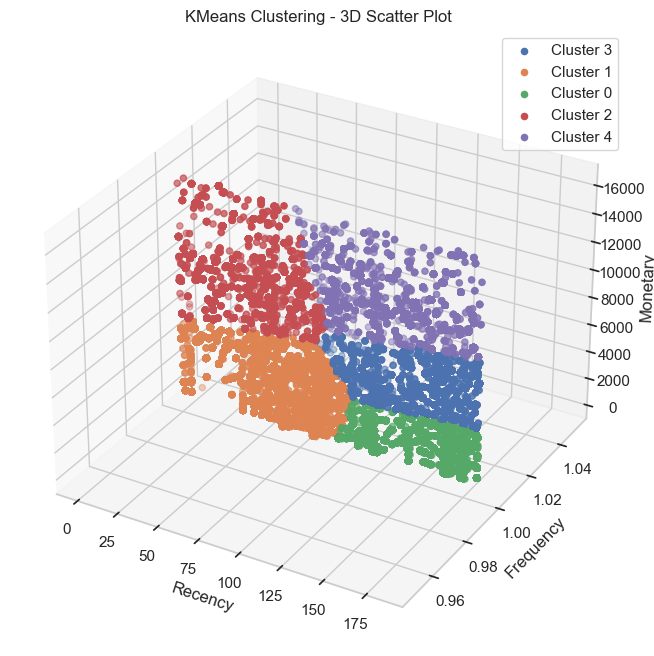

In [32]:
plot_scatter_matrix(df_rfm_with_clusters, 'Cluster')

plot_clusters_3d(df_rfm_with_clusters)

## Calculate CLV 
ARPU ---> Average Revenue per User 

Churn customer --->	A customer who did not purchase in the last 365 days


### Customer Lifetime Value (CLV)

In reference to this question, with data considered up to the end of a year, the churn rate for the preceding year has been calculated.

In [33]:
def filter_data_by_month_and_year(data: pd.DataFrame, month: int, year: int) -> pd.DataFrame:
  """
  Filters the given data by the specified month and year.

  Parameters:
  data (pd.DataFrame): The input data.
  month (int): The month to filter by.
  year (int): The year to filter by.

  Returns:
  pd.DataFrame: The filtered data.
  """

  return data[(data['Persian_Month'] == month) & (data['Persian_Year'] == year)]


def calculate_churned_customers(data: pd.DataFrame, churn_period_days: int) -> List[int]:
  """
  Calculates the churned customers for the given data and churn period.

  Parameters:
  data (pd.DataFrame): The input data.
  churn_period_days (int): The number of days for the churn period.

  Returns:
  List[int]: The unique customer IDs of the churned customers.
  """

  max_date = data['Edited_Date'].max()
  churn_period = max_date - pd.Timedelta(days=churn_period_days)
  return data[data['Edited_Date'] < churn_period]['CustomerID'].unique()


def calculate_metrics(data: pd.DataFrame) -> Tuple[float, int, float]:
  """
  Calculates the total revenue, total customers, and average revenue per user (ARPU) for the given data.

  Parameters:
  data (pd.DataFrame): The input data.

  Returns:
  Tuple[float, int, float]: The total revenue, total customers, and ARPU.
  """

  total_revenue = data['Revenue'].sum()
  total_customers = data['CustomerID'].nunique()
  arpu = total_revenue / total_customers
  return total_revenue, total_customers, arpu


def calculate_churn_rate(churned_customers: List[int], total_customers: int) -> float:
  """
  Calculates the churn rate for the given churned customers and total customers.

  Parameters:
  churned_customers (List[int]): The list of churned customers.
  total_customers (int): The total number of customers.

  Returns:
  float: The churn rate.
  """

  return len(churned_customers) / total_customers


def calculate_clv(arpu: float, churn_rate: float) -> float:
  """
  Calculates the customer lifetime value (CLV) for the given ARPU and churn rate.

  Parameters:
  arpu (float): The average revenue per user.
  churn_rate (float): The churn rate.

  Returns:
  float: The CLV.
  """
  return arpu / churn_rate


def calculate_average_revenue(data: pd.DataFrame) -> pd.DataFrame:
  """
  Calculates the average revenue for each customer in the given data.

  Parameters:
  data (pd.DataFrame): The input data.

  Returns:
  pd.DataFrame: The average revenue for each customer.
  """

  return data.groupby('CustomerID')['Revenue'].mean().reset_index()


def merge_average_revenue(data: pd.DataFrame, average_revenue: pd.DataFrame) -> pd.DataFrame:
  """
  Merges the given data with the average revenue data.

  Parameters:
  data (pd.DataFrame): The input data.
  average_revenue (pd.DataFrame): The average revenue data.

  Returns:
  pd.DataFrame: The merged data.
  """

  return data.merge(average_revenue, how='left', on='CustomerID')


def calculate_number_churned_rate(churned_data: pd.DataFrame, total_customers: int) -> float:
  """
  Calculates the number churned rate for the given churned data and total customers.

  Parameters:
  churned_data (pd.DataFrame): The churned data.
  total_customers (int): The total number of customers.

  Returns:
  float: The number churned rate.
  """

  number_churned = churned_data['CustomerID'].nunique()
  
  return number_churned / total_customers

In [34]:
def analyze_customer_lifetime_value(df: pd.DataFrame) -> float:
   """
   Analyzes the customer lifetime value (CLV) for a given dataframe.

   Parameters:
   df (pd.DataFrame): The input dataframe.

   Returns:
   float: The calculated CLV.
   """
   
   filter_customer_by_month = filter_data_by_month_and_year(df, month=1, year=1398)
   df_clv = df[df['CustomerID'].isin(filter_customer_by_month['CustomerID'].unique())]

   churned_customers = calculate_churned_customers(df_clv, churn_period_days=365)
   total_revenue, total_customers, arpu = calculate_metrics(df_clv)
   churn_rate = calculate_churn_rate(churned_customers, total_customers)
   clv = calculate_clv(arpu, churn_rate)

   df_arpu = calculate_average_revenue(df_clv)
   df_arpu.rename(columns={'Revenue': 'Avg Revenue for Customer'}, inplace=True)

   df_clv = merge_average_revenue(df_clv, df_arpu)
   df_clv['Churned'] = df_clv['CustomerID'].isin(churned_customers)

   total_revenue, total_customers, arpu = calculate_metrics(df_clv)
   number_churned_rate = calculate_number_churned_rate(df_clv[df_clv['Churned']], total_customers)
   clv = calculate_clv(arpu, number_churned_rate)

   return clv

In [35]:
customer_lifetime_value = analyze_customer_lifetime_value(df)
customer_lifetime_value

12305.795069337444